In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../../datasets/credit_scoring_sample.csv')

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

In [4]:
df.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [5]:
#let's create a function that will replace all NaN values with the median for each feature
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

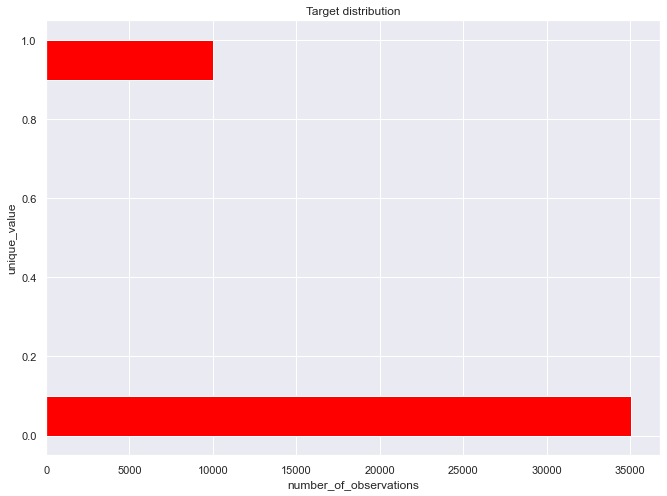

In [6]:
#check the class balance
ax = df['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
df['SeriousDlqin2yrs'].value_counts()/df.shape[0]

In [7]:
independent_columns_names = [x for x in df if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [8]:
#let's fill all NaN
table = fill_nan(df)

In [9]:
#separate the target variable
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [10]:
def get_bootstrap_samples(data, n_samples):
    """Generate samples using bootstrapping."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """Make an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# Save the ages of those who let a delay
churn = df[df['SeriousDlqin2yrs'] == 1]['age'].values

# Set the random seed for reproducibility
np.random.seed(0)

# Generate bootstrap samples and calculate the mean for each sample
churn_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn, 1000)]

# Print the interval estimate for the sample means
print("Mean interval", stat_intervals(churn_mean_scores, 0.1))

Mean interval [45.71379414 46.12700479]


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [12]:
lr = LogisticRegression(random_state=5, class_weight='balanced')

In [13]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [15]:
grid = GridSearchCV(lr, parameters, cv=5, n_jobs=-1, scoring='roc-auc')

In [16]:
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5),
             n_jobs=-1, param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)})

In [17]:
grid.best_params_

{'C': 0.0001}

In [19]:
grid.best_estimator_

LogisticRegression(C=0.0001, class_weight='balanced', random_state=5)

In [22]:
clf = grid.best_estimator_

In [32]:
for i in clf.coef_:
    for j, x in zip(i, X.columns):
        print(j, x)


-0.009587333564874598 age
0.27179448198626305 NumberOfTime30-59DaysPastDueNotWorse
-6.459678054256722e-06 DebtRatio
0.20588381363109443 NumberOfTimes90DaysLate
0.09624601224085698 NumberOfTime60-89DaysPastDueNotWorse
-7.0121550841101334e-06 MonthlyIncome
0.1324441399649672 NumberOfDependents
